In [2]:
import os
import gdown
FILE_PATH = 'Epil_features.json.gzip'

if not os.path.exists(FILE_PATH):
    gdown.download('https://drive.google.com/uc?id=143dJfY1_U-p8elbvSzwe0TTHGcDo3PYv', 
                './'+FILE_PATH, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=143dJfY1_U-p8elbvSzwe0TTHGcDo3PYv
To: /content/Epil_features.json.gzip
100%|██████████| 151k/151k [00:00<00:00, 39.8MB/s]


In [3]:
import matplotlib.pyplot as plt   # for plotting
import numpy as np                # arrays
import pickle                     # saving python objects
import pandas as pd               # dataframes

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# load features dataframe
feature_df = pd.read_json(FILE_PATH, orient='index', compression = 'gzip')

# display examples of the data
display(feature_df.info())
display(feature_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 500 non-null    object 
 1   location              500 non-null    object 
 2   file_id               500 non-null    object 
 3   CZ|2_4Hz              500 non-null    float64
 4   CZ|4_8Hz              500 non-null    float64
 5   CZ|8_12Hz             500 non-null    float64
 6   CZ|12_30Hz            500 non-null    float64
 7   CZ|30_70Hz            500 non-null    float64
 8   CZ|Ratio_3_12/2_30Hz  500 non-null    float64
 9   CZ|D6_mean            500 non-null    float64
 10  CZ|D5_mean            500 non-null    float64
 11  CZ|D4_mean            500 non-null    float64
 12  CZ|D3_mean            500 non-null    float64
 13  CZ|D2_mean            500 non-null    float64
 14  CZ|D1_mean            500 non-null    float64
 15  CZ|D6_std             5

None

,class,location,file_id,CZ|2_4Hz,CZ|4_8Hz,CZ|8_12Hz,CZ|12_30Hz,CZ|30_70Hz,CZ|Ratio_3_12/2_30Hz,CZ|D6_mean,CZ|D5_mean,CZ|D4_mean,CZ|D3_mean,CZ|D2_mean,CZ|D1_mean,CZ|D6_std,CZ|D5_std,CZ|D4_std,CZ|D3_std,CZ|D2_std,CZ|D1_std,CZ|D6_ratio,CZ|D5_ratio,CZ|D4_ratio,CZ|D3_ratio,CZ|D2_ratio,CZ|D1_ratio,CZ|D6_mean_abs,CZ|D5_mean_abs,CZ|D4_mean_abs,CZ|D3_mean_abs,CZ|D2_mean_abs,CZ|D1_mean_abs,CZ|D6_LSWT,CZ|D5_LSWT,CZ|D4_LSWT,CZ|D3_LSWT,CZ|D2_LSWT,CZ|D1_LSWT
0,baseline,intracranial epileptogenic zone,F001,77.429564,28.734279,13.102026,2.467909,0.462172,0.138219,-1.758529,3.689356,0.572214,0.401766,-0.008293,-0.041443,94.954945,77.076934,36.437346,18.901216,6.525675,2.479045,1.272058,1.147393,0.756706,0.877359,0.631333,0.362810,76.722313,60.313528,28.409123,14.772764,5.266416,1.910710,0.000000,6.427250,5.613190,5.805773,4.749819,3.665018
1,baseline,intracranial epileptogenic zone,F002,1060.585071,480.018796,201.886582,29.713494,4.070126,0.140057,-43.528777,5.563645,-5.458138,-1.311734,0.120496,-0.002805,399.209789,281.923087,151.139973,67.289651,18.696915,3.012844,1.878949,0.824373,0.906137,0.687953,0.514802,0.208105,281.597393,149.869616,81.999218,31.116812,8.462824,1.761159,0.000000,8.241056,7.388935,7.770027,8.062119,8.020356
2,baseline,intracranial epileptogenic zone,F003,316.076591,186.372298,135.970946,20.841888,2.781560,0.148809,7.140095,-10.223593,1.088205,-1.555793,-0.034026,-0.034373,357.861759,132.001620,118.527127,55.385295,15.882118,4.972672,2.901753,0.533720,1.222865,0.809146,0.499067,0.210005,298.635855,102.915688,87.018413,39.403208,10.376156,2.179047,7.534104,0.000000,7.412203,6.336933,7.197397,7.170449
3,baseline,intracranial epileptogenic zone,F004,213.966621,91.338657,34.191639,3.157286,0.573759,0.064002,-15.857898,-3.700006,3.257209,-0.135347,0.081712,-0.032627,165.928055,119.045182,59.769483,22.377317,6.419182,2.324330,1.400790,1.052269,0.839701,0.687769,0.516294,0.365782,127.731141,91.185066,45.580184,17.377872,4.953816,1.812019,0.000000,6.422032,7.582963,6.947882,7.086014,6.950912
4,baseline,intracranial epileptogenic zone,F005,973.296659,385.347164,218.880920,47.891201,7.560384,0.183348,-21.433089,-34.709688,5.766435,-3.044324,0.069729,0.081691,346.795965,216.454349,152.238202,75.145144,28.542184,6.026236,1.648172,0.853625,1.051711,0.801236,0.625299,0.198041,270.422836,164.074428,113.995056,52.705751,17.566081,3.478807,8.055723,0.000000,8.726303,8.031105,8.460379,8.480473


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
RANDOM_STATE = 0

feature_reduced = feature_df[feature_df.location != 'surface']
feature_reduced_drop = feature_reduced.drop(['class', 'file_id', 'location'], 
                                            axis='columns')
data_x = feature_reduced_drop.values

# make a label encoder
le = LabelEncoder()
# change the string labels to ints
data_y = le.fit_transform(feature_reduced['class'])
    
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=TEST_SIZE, 
                                                  random_state=RANDOM_STATE)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(192, 36) (48, 36) (60, 36)
(192,) (48,) (60,)


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
pipe_reg = Pipeline([('scl', StandardScaler()),
                     ('clf', LogisticRegression(class_weight='balanced',
                                                solver = 'liblinear',
                                                random_state=RANDOM_STATE))])

# Support Vector Machine
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(kernel='rbf', 
                                class_weight = 'balanced',
                                probability=True,
                                random_state=RANDOM_STATE))])

# Decision Tree
DT = DecisionTreeClassifier(random_state=RANDOM_STATE)

# K-Nearest Neighbours
pipe_kkn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier())])

# list of classifier names
classifier_names = ['Logistic Regression', 'Support Vector Machine', 
                    'Decision Tree', 'K-Nearest Neighbors']

# list of classifiers
classifiers = [pipe_reg, pipe_svc, DT, pipe_kkn]

# fit all the classifiers to the training data
for classifier in classifiers:
  classifier.fit(X_train, y_train)

Performance Evaluation


Metrics

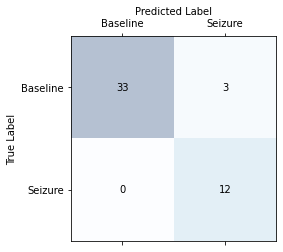

In [6]:
from sklearn.metrics import confusion_matrix

def pretty_confusion_matrix(confmat):

    # this creates the matplotlib graph to make the confmat look nicer
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
       
    # change the labels
    ax.set_xticklabels(['']+['Baseline', 'Seizure'])
    ax.set_yticklabels(['']+['Baseline', 'Seizure'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')

    plt.tight_layout()
    
    plt.show()
    
    
# use the first classifier to predict the validation set    
predictions = classifiers[1].predict(X_val)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_val, y_pred=predictions)

# use the pretty function to make it nicer
pretty_confusion_matrix(confmat)

In [7]:
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

ERR = (FP+FN)/(FP+FN+TP+TN)
ACC = 1-ERR
TPR = TP/(FN+TP)
FPR = FP/(FP+TN)
PRE = TP/(TP+FP)
REC = TP/(FN+TP)
F1 = 2*((PRE*REC)/(PRE+REC))

print('True positive rate (TPR): %.3f' % TPR)
print('False positive rate (FPR): %.3f' % FPR)
print('Error (ERR): %.3f' % ERR)
print()
print('Accuracy (ACC): %.3f' % ACC)
print('Precision (PRE): %.3f' % PRE)
print('Recall (REC): %.3f' % REC)
print('F1-score (F1): %.3f' % F1)

True positive rate (TPR): 1.000
False positive rate (FPR): 0.083
Error (ERR): 0.062

Accuracy (ACC): 0.938
Precision (PRE): 0.800
Recall (REC): 1.000
F1-score (F1): 0.889


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

print('Accuracy (ACC): %.3f' % accuracy_score(y_true=y_val, y_pred=predictions))
print('Precision (PRE): %.3f' % precision_score(y_true=y_val, y_pred=predictions))
print('Recall (REC): %.3f' % recall_score(y_true=y_val, y_pred=predictions))
print('F1-score (F1): %.3f' % f1_score(y_true=y_val, y_pred=predictions))

Accuracy (ACC): 0.938
Precision (PRE): 0.800
Recall (REC): 1.000
F1-score (F1): 0.889


In [9]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(y_val, 
                                   predictions, 
                                   labels=None, 
                                   target_names=['Baseline', 'Seizure'], 
                                   sample_weight=None, 
                                   digits=2, 
                                   output_dict=True))

,Baseline,Seizure,accuracy,macro avg,weighted avg
precision,1.000000,0.800000,0.9375,0.900000,0.950000
recall,0.916667,1.000000,0.9375,0.958333,0.937500
f1-score,0.956522,0.888889,0.9375,0.922705,0.939614
support,36.000000,12.000000,0.9375,48.000000,48.000000


Logistic Regression


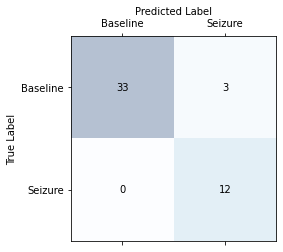

Support Vector Machine


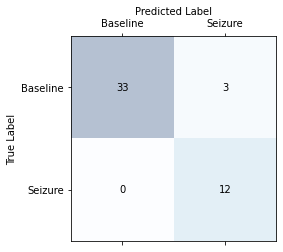

Decision Tree


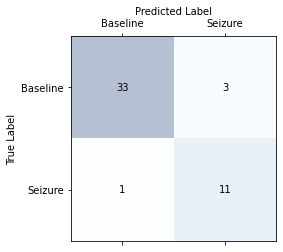

K-Nearest Neighbors


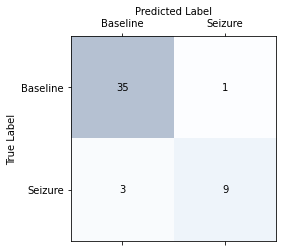

In [10]:
for i, classifier in enumerate(classifiers):
  print(color.BOLD+color.UNDERLINE+classifier_names[i]+color.END)

  predictions = classifier.predict(X_val)

  confmat = confusion_matrix(y_true=y_val, y_pred=predictions)

  pretty_confusion_matrix(confmat)

In [11]:
for i, classifier in enumerate(classifiers):
  predictions = classifier.predict(X_val)

  classifier_score_df = pd.DataFrame(
      classification_report(y_val, 
                            predictions,
                            target_names=['Baseline', 'Seizure'],
                            digits=2, 
                            output_dict=True))
  
  classifier_score_df.index.name = 'Metric'
  classifier_score_df['Classifier'] = classifier_names[i]
  classifier_score_df = classifier_score_df.set_index('Classifier', append=True)
  
  if i == 0:
    all_scores = classifier_score_df

  else:
    all_scores = pd.concat([all_scores, classifier_score_df])
        
all_scores.sort_index()

Baseline    Seizure  ...  macro avg  weighted avg
Metric    Classifier                                    ...                         
f1-score  Decision Tree            0.942857   0.846154  ...   0.894505      0.918681
          K-Nearest Neighbors      0.945946   0.818182  ...   0.882064      0.914005
          Logistic Regression      0.956522   0.888889  ...   0.922705      0.939614
          Support Vector Machine   0.956522   0.888889  ...   0.922705      0.939614
precision Decision Tree            0.970588   0.785714  ...   0.878151      0.924370
          K-Nearest Neighbors      0.921053   0.900000  ...   0.910526      0.915789
          Logistic Regression      1.000000   0.800000  ...   0.900000      0.950000
          Support Vector Machine   1.000000   0.800000  ...   0.900000      0.950000
recall    Decision Tree            0.916667   0.916667  ...   0.916667      0.916667
          K-Nearest Neighbors      0.972222   0.750000  ...   0.861111      0.916667
          Logistic Regression      0.916667   1.000000  ...   0.958333      0.937500
          Support Vector Machine   0.916667   1.000000  ...   0.958333      0.937500
support   Decision Tree           36.000000  12.000000  ...  48.000000     48.000000
          K-Nearest Neighbors     36.000000  12.000000  ...  48.000000     48.000000
          Logistic Regression     36.000000  12.000000  ...  48.000000     48.000000
          Support Vector Machine  36.000000  12.000000  ...  48.000000     48.000000

[16 rows x 5 columns]

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


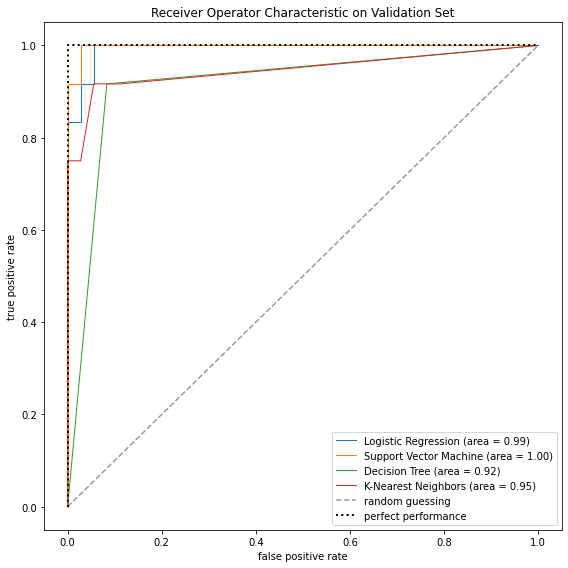

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.externals import joblib
import re

def ROC(classifiers, classifier_names, X_train, 
        X_val, y_train, y_val, image_file_path):
  
  # this creates the matplotlib graph to make the confmat look nicer
  fig, ax = plt.subplots(figsize=(8, 8))
  # for each classifier...
  for i, classifer in enumerate(classifiers):
    # fit the pipeline
    probas = classifer.fit(X_train,
                                y_train).predict_proba(X_val)

    # get the roc curve info
    fpr, tpr, thresholds = roc_curve(y_val, 
                                     probas[:, 1], 
                                     pos_label=1)

    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, 
             tpr, 
             lw=1, 
             label='{} (area = %0.2f)'.format(classifier_names[i]) %roc_auc)

  plt.plot([0, 1], 
           [0, 1], 
           linestyle='--', 
           color=(0.6, 0.6, 0.6), 
           label='random guessing')

  plt.plot([0, 0, 1], 
           [0, 1, 1], 
           lw=2, 
           linestyle=':', 
           color='black', 
           label='perfect performance')

  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')
  plt.title('Receiver Operator Characteristic on Validation Set')
  plt.legend(loc="lower right", fontsize ='medium')

  plt.tight_layout()
  plt.savefig(image_file_path, dpi=300)
  plt.show()    
    

ROC(classifiers, classifier_names, X_train, X_val, y_train, 
    y_val, 'Classifiers_ROC.png')